In [7]:
import logging
import os
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset

import onnx
from onnxsim import simplify

In [2]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5,
                export_onnx=False,
                export_dir='models'):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

         # Export the model
        if export_onnx:
          img = torch.zeros(1, 3, 512, 512).to(device)
          onnx_path = os.path.join(export_dir,"unet_onnx.onnx")
          torch.onnx.export(net,               # model being run
                            img,                         # model input (or a tuple for multiple inputs)
                            onnx_path,   # where to save the model (can be a file or file-like object)
                            #verbose=True,
                            #export_params=True,        # store the trained parameter weights inside the model file
                            opset_version=11,          # the ONNX version to export the model to
                            #do_constant_folding=True,  # whether to execute constant folding for optimization
                            input_names = ['input'],   # the model's input names
                            #output_names = ['output'], # the model's output names
                            output_names = ['output']) # the model's output names
                            #dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                            #              'output' : {0 : 'batch_size'}})
          model = onnx.load(onnx_path)
          model_sim, check = simplify(model)
          assert check, "Simplified ONNX model could not be validated"
          onnx_sim_path = os.path.join(export_dir, 'unet_onnx_sim.onnx')
          onnx.save(model_sim, onnx_sim_path)

    return full_mask > out_threshold, full_mask

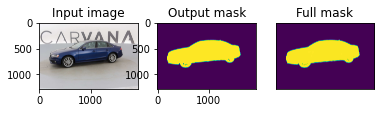

In [9]:
model = '../checkpoints/CP_epoch10.pth'
scale = 0.5
mask_threshold = 0.8
export_onnx = False
no_save = True
viz = True
in_files = ['../data/imgs/0cdf5b5d0ce1_04.jpg']
out_files = []

net = UNet(n_channels=3, n_classes=1)

logging.info("Loading model {}".format(model))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))

logging.info("Model loaded !")

for i, fn in enumerate(in_files):
    logging.info("\nPredicting image {} ...".format(fn))

    img = Image.open(fn)

    mask,full_mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=scale,
                        out_threshold=mask_threshold,
                        device=device,
                        export_onnx=export_onnx)

    if not no_save:
        out_fn = out_files[i]
        result = mask_to_image(mask)
        result.save(out_files[i])

        logging.info("Mask saved to {}".format(out_files[i]))

    if viz:
        logging.info("Visualizing results for image {}, close to continue ...".format(fn))
        plot_img_and_mask(img, mask, full_mask)